
# **Time Series Forecasting with ARIMA and SARIMA Models**  

## **Project Overview**  
This project applies **ARIMA (AutoRegressive Integrated Moving Average)**, **SARIMA (Seasonal ARIMA)**,**Prophet**, **LSTM** models to analyze and forecast **electricity sales trends** in the United States. Using **monthly electricity consumption data from 2010 to 2023**, the study aims to capture long-term trends and seasonal patterns in power usage across different economic sectors.  

By leveraging **time series modeling techniques**, this analysis provides **data-driven insights** for energy policymakers, utility companies, and researchers interested in demand forecasting.  

---  

## **Dataset Overview**  
- **Source:** U.S. Energy Information Administration (EIA) - Monthly Form EIA-861M  
- **Time Frame:** January 2010 – December 2023 (168 monthly observations)  
- **Key Variable:**  
  - `Sales_total` → Aggregated electricity consumption across **residential, commercial, industrial, and transportation** sectors.  
- **Other Features:** Revenue, customer counts, and sector-specific sales data.  

---

## **Data Preprocessing**  
To ensure accurate forecasting, several preprocessing steps were applied:  
✔️ **Date Formatting**: Combined `Year` and `Month` into a **datetime index** for time series analysis.  
✔️ **Data Cleaning**: Removed commas from numerical values and converted key variables to float format.  
✔️ **Stationarity Check**: Conducted **Augmented Dickey-Fuller (ADF) test** to assess stationarity.  
✔️ **Differencing & Transformation**: Applied **first-order differencing** to stabilize the series before modeling.  

---


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings

In [2]:
# Load datasets
data = pd.read_excel('Elec_sales.xlsx', engine='openpyxl')
print(data.head())
print(data.shape)
print(data.dtypes)

   Year  Month  Revenue_residential  Sales_residential  Customers_residential  \
0  2023     12             18659020          118916960              141942234   
1  2023     11             16501182          101906587              141638998   
2  2023     10             17021917          103313774              141873678   
3  2023      9             21601604          132807006              141394603   
4  2023      8             25693309          161460192              142091093   

   Price_residential  Revenue_commercial  Sales_commercial  \
0          15.690798          13652809.0         111511827   
1          16.192458          13645725.0         109756483   
2          16.475941          15047055.0         118207853   
3          16.265410          16537574.0         126545787   
4          15.913092          18102204.0         138389572   

   Customers_commercial  Price_commercial  ...  Customers_industrial  \
0              19410068         12.243373  ...               1083495

In [3]:
# Remove commas and convert specified columns to numeric
columns_to_clean = [
    "Revenue_residential", "Sales_residential", "Customers_residential",
    "Revenue_commercial", "Sales_commercial", "Customers_commercial",
    "Revenue_industrial", "Sales_industrial", "Customers_industrial",
    "Revenue_transportation", "Sales_transportation", "Revenue_total",
    "Sales_total", "Customers_total"
]

for col in columns_to_clean:
    data[col] = data[col].replace(",", "", regex=True).astype(float)

In [4]:
# Combine 'Year' and 'Month' into a datetime index
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
data.set_index('Date', inplace=True)

In [5]:
# Check for missing values
print(data.isnull().sum())

Year                        0
Month                       0
Revenue_residential         0
Sales_residential           0
Customers_residential       0
Price_residential           0
Revenue_commercial          0
Sales_commercial            0
Customers_commercial        0
Price_commercial            0
Revenue_industrial          0
Sales_industrial            0
Customers_industrial        0
Price_industrial            0
Revenue_transportation      0
Sales_transportation        0
Customers_transportation    0
Price_transportation        0
Revenue_total               0
Sales_total                 0
Customers_total             0
Price_total                 0
dtype: int64


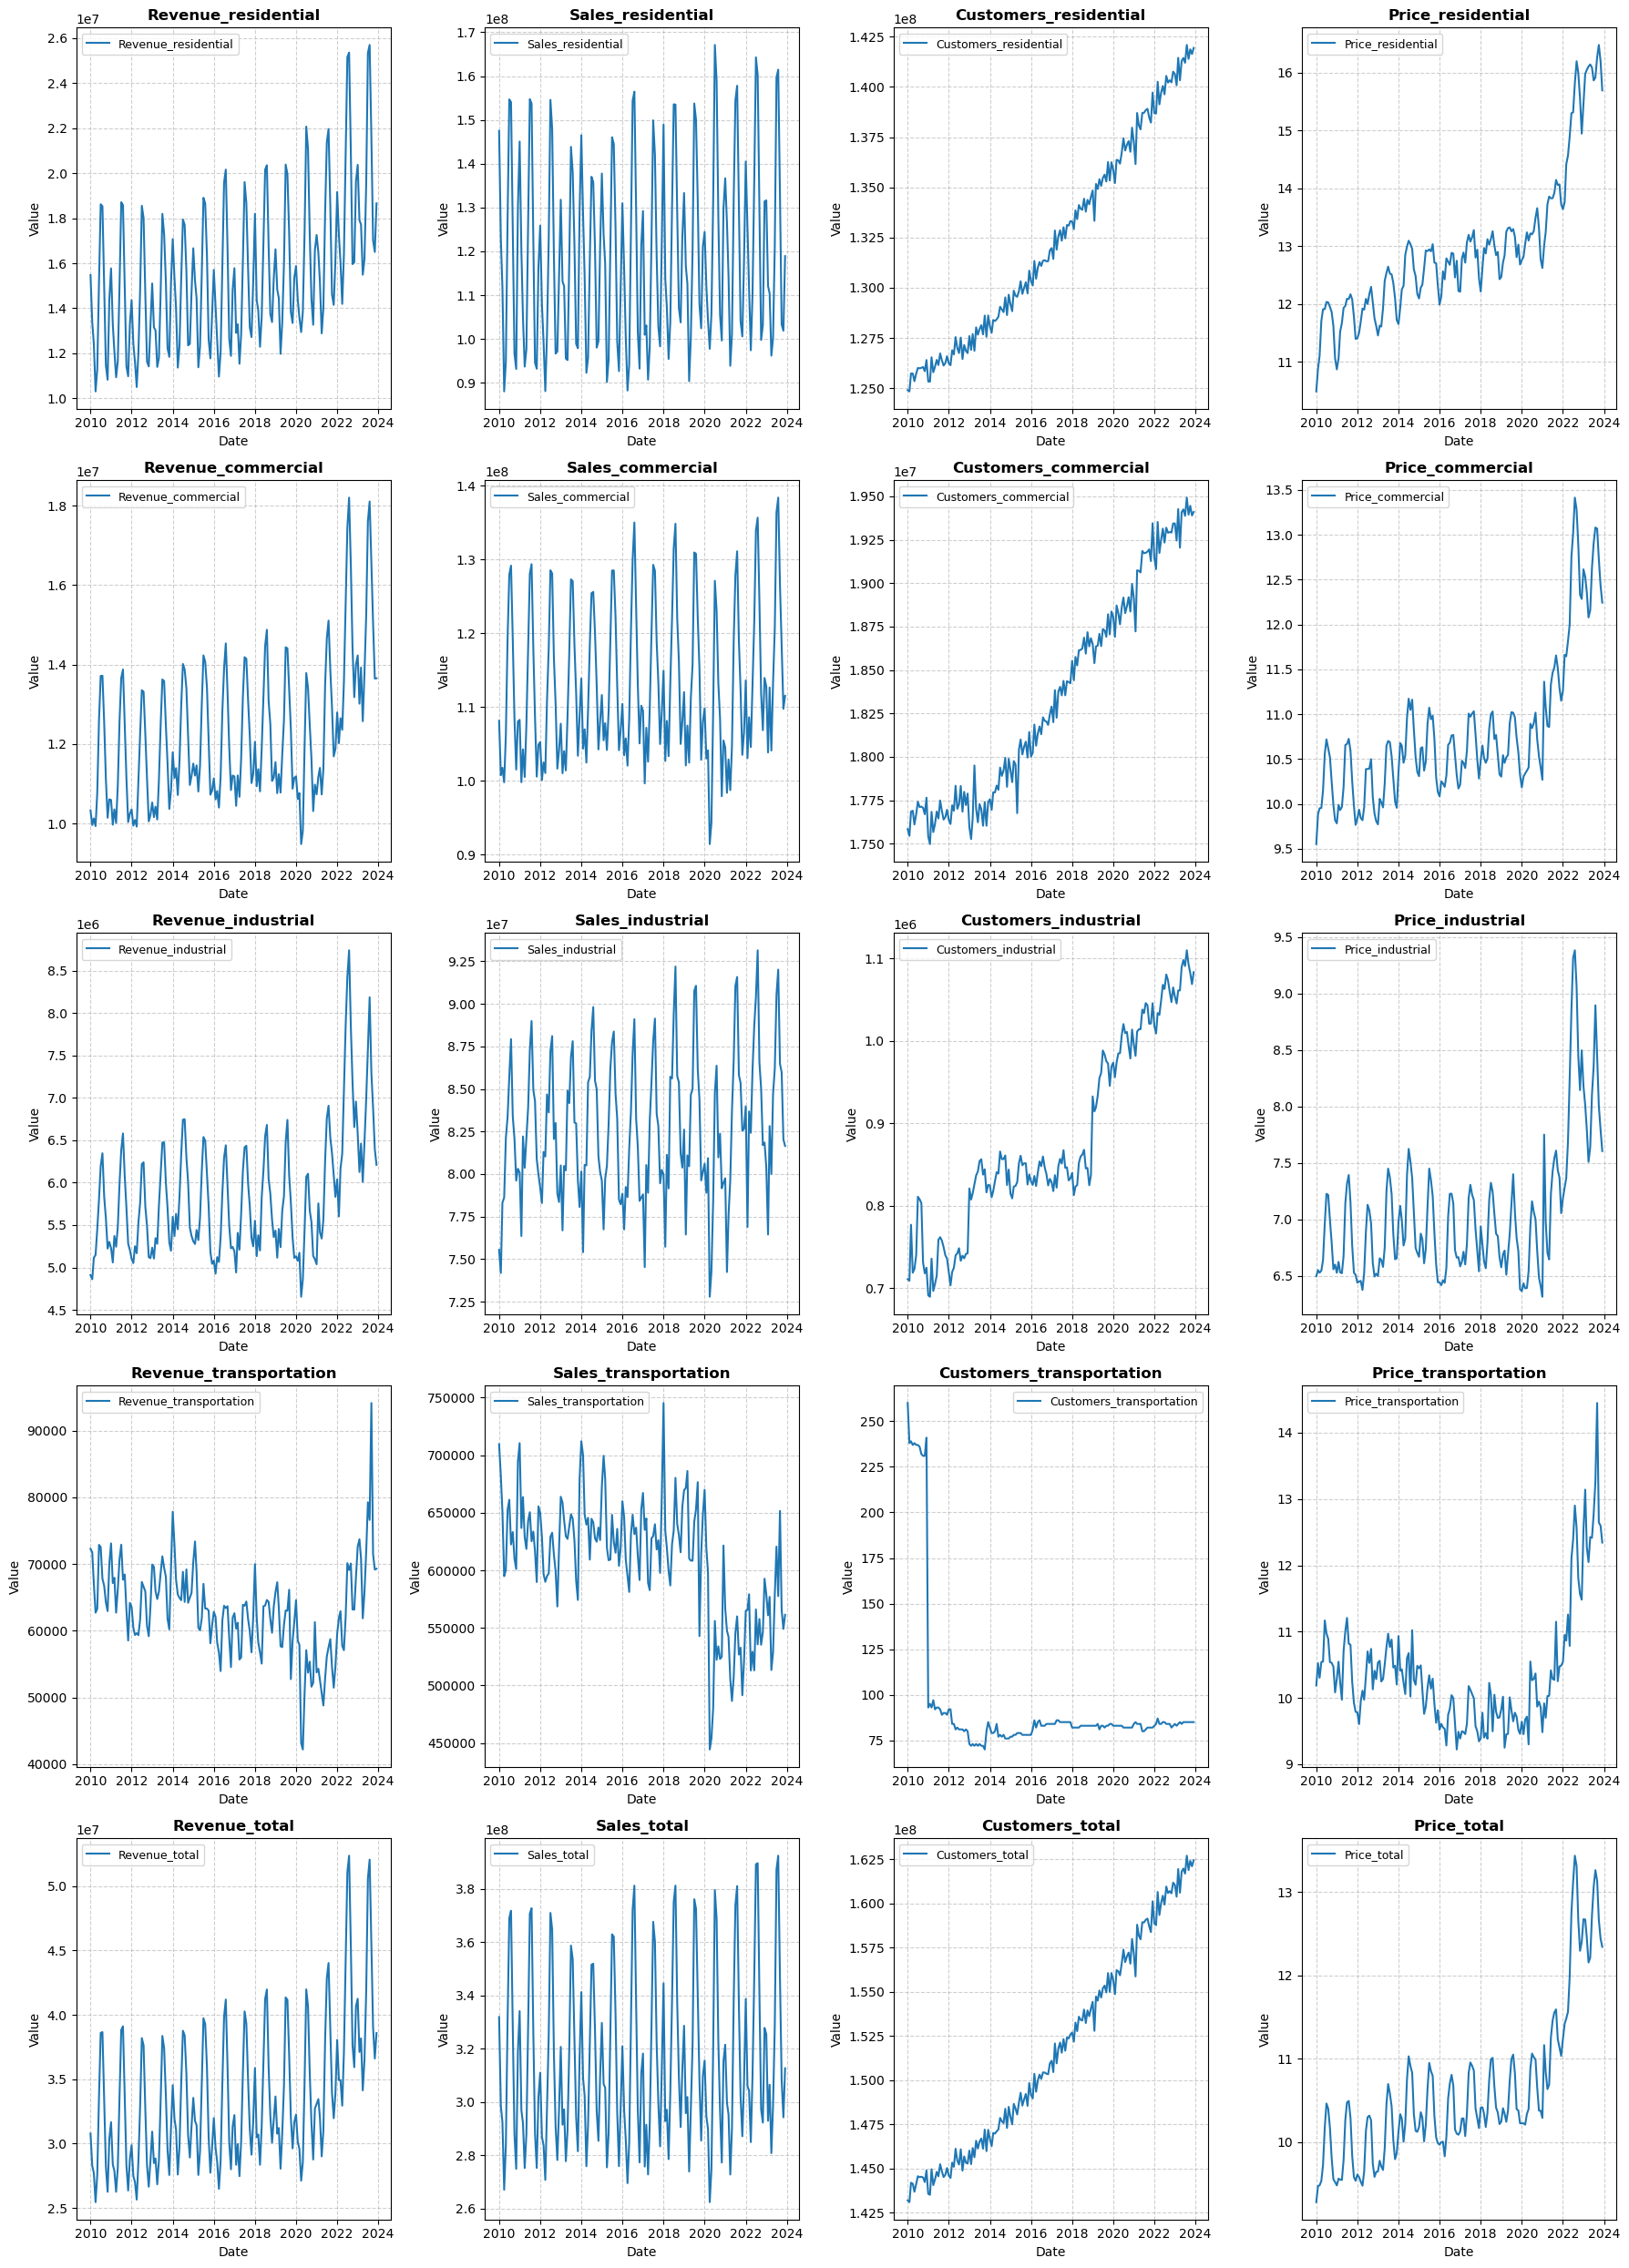

In [6]:
# --- Data visualization ---
# Time series dataset visualization
variables_to_plot = [
    "Revenue_residential", "Sales_residential", "Customers_residential", "Price_residential",
    "Revenue_commercial", "Sales_commercial", "Customers_commercial", "Price_commercial",
    "Revenue_industrial", "Sales_industrial", "Customers_industrial", "Price_industrial",
    "Revenue_transportation", "Sales_transportation", "Customers_transportation", "Price_transportation",
    "Revenue_total", "Sales_total", "Customers_total", "Price_total"
]

num_vars = len(variables_to_plot)
n_cols = 4  # Number of columns in the grid
n_rows = -(-num_vars // n_cols)  # Ceiling division for rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, var in enumerate(variables_to_plot):
    axes[i].plot(data.index, data[var], label=var, linewidth=1.5)
    axes[i].set_title(var, fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Date", fontsize=10)
    axes[i].set_ylabel("Value", fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, linestyle='--', alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [7]:
# --- Descriptive statistics ---
sales_total_stats = data['Sales_total'].describe()
print(sales_total_stats)

count    1.680000e+02
mean     3.150593e+08
std      3.189994e+07
min      2.624006e+08
25%      2.914379e+08
50%      3.081533e+08
75%      3.321485e+08
max      3.924360e+08
Name: Sales_total, dtype: float64


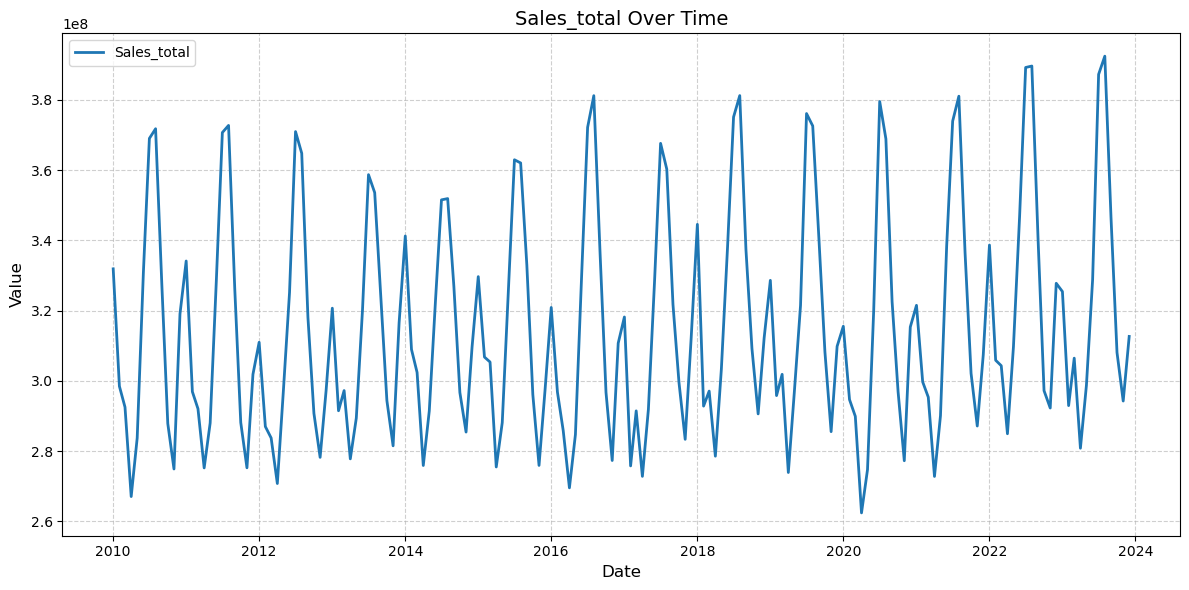

In [8]:
# --- Plotting Sales_total ---
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Sales_total"], label="Sales_total", linewidth=2)
plt.title("Sales_total Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Augmented Dicky Fuller test

In [9]:
# --- Stationarity check ---
# Augmented Dickey-Fuller test for stationarity
series = data['Sales_total']
result = adfuller(series)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -2.340837748506493
p-value: 0.1591349369457421
Critical Values: {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}
The time series is not stationary.


## First Order Differencing

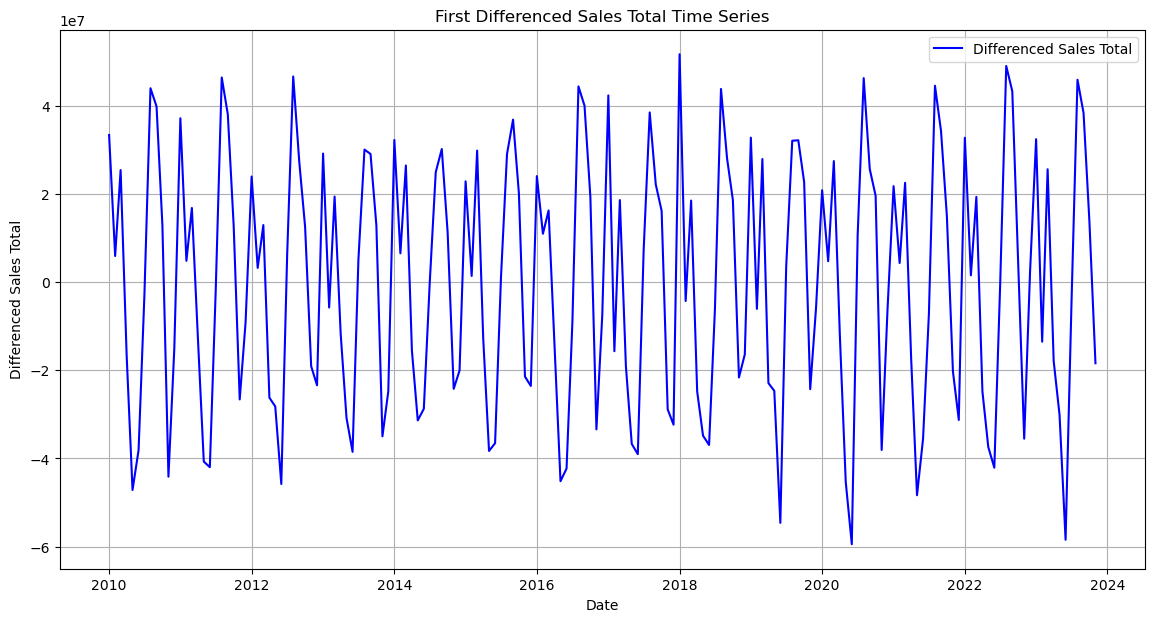

ADF Statistic: -6.9737580052237025
p-value: 8.532554237371909e-10
Critical Values: {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}
The differenced series is stationary.


In [10]:
# First-order differencing
data['Sales_total_diff'] = data['Sales_total'].diff().dropna()

plt.figure(figsize=(14, 7))
plt.plot(data.index[1:], data['Sales_total_diff'][1:], label='Differenced Sales Total', color='blue')
plt.title('First Differenced Sales Total Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Sales Total')
plt.grid(True)
plt.legend()
plt.show()

result_diff = adfuller(data['Sales_total_diff'].dropna())
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:', result_diff[4])

if result_diff[1] <= 0.05:
    print("The differenced series is stationary.")
else:
    print("The differenced series is still not stationary.")


<Figure size 2000x1200 with 0 Axes>

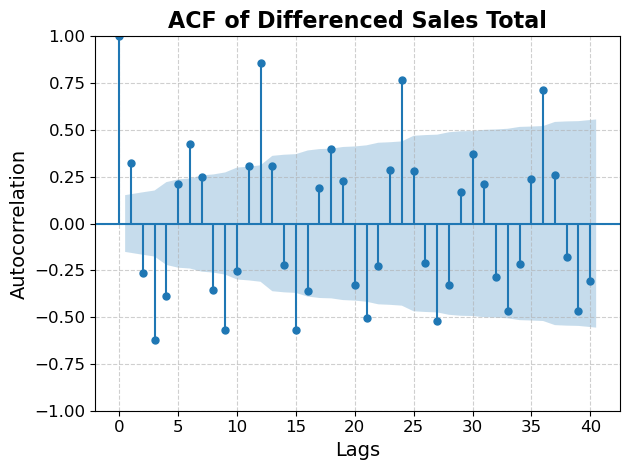

In [11]:
# --- ACF and PACF plots ---
# Plot ACF
plt.figure(figsize=(20, 12))
plot_acf(data['Sales_total_diff'].dropna(), lags=40)
plt.title('ACF of Differenced Sales Total', fontsize=16, fontweight='bold')
plt.xlabel('Lags', fontsize=14)
plt.ylabel('Autocorrelation', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<Figure size 2000x1200 with 0 Axes>

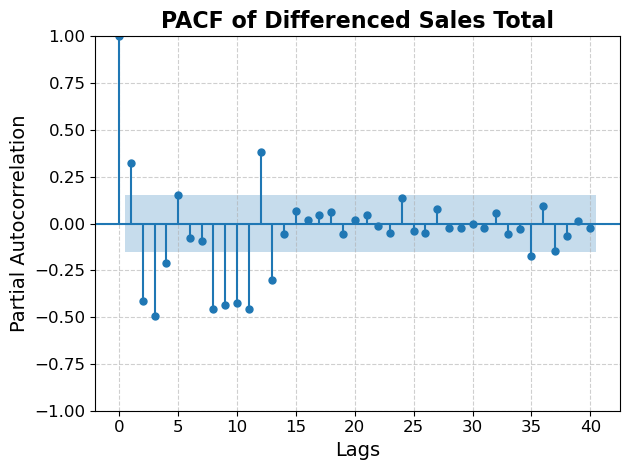

In [12]:
# Plot PACF
plt.figure(figsize=(20, 12))
plot_pacf(data['Sales_total_diff'].dropna(), lags=40)
plt.title('PACF of Differenced Sales Total', fontsize=16, fontweight='bold')
plt.xlabel('Lags', fontsize=14)
plt.ylabel('Partial Autocorrelation', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## ARIMA

In [13]:
# --- ARIMA Model ---
# Grid search for ARIMA parameters
warnings.filterwarnings("ignore")

def arima_grid_search(time_series, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        try:
            model = ARIMA(time_series, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
            print(f"ARIMA{(p, d, q)} AIC:{aic}")
        except Exception as e:
            print(f"ARIMA{(p, d, q)} failed. Error: {e}")
    print(f"Best ARIMA Model: ARIMA{best_cfg} AIC:{best_score}")
    return best_cfg

In [14]:
# Define parameter ranges for grid search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

In [15]:
# Perform grid search
best_order = arima_grid_search(data['Sales_total_diff'].dropna(), p_values, d_values, q_values)

ARIMA(0, 0, 0) AIC:6898.193973103793
ARIMA(0, 0, 1) AIC:6184.8802930167
ARIMA(0, 0, 2) AIC:6163.984054549923
ARIMA(0, 1, 0) AIC:6219.929602285402
ARIMA(0, 1, 1) AIC:6220.872883578366
ARIMA(0, 1, 2) AIC:6155.741677445461
ARIMA(1, 0, 0) AIC:6192.802948998711
ARIMA(1, 0, 1) AIC:6185.816744513442
ARIMA(1, 0, 2) AIC:6146.219076762212
ARIMA(1, 1, 0) AIC:6221.359804089588
ARIMA(1, 1, 1) AIC:6161.510760885655
ARIMA(1, 1, 2) AIC:6155.699964243619
ARIMA(2, 0, 0) AIC:6162.791209362127
ARIMA(2, 0, 1) AIC:6097.183719668221
ARIMA(2, 0, 2) AIC:6067.726314954987
ARIMA(2, 1, 0) AIC:6217.700177031489
ARIMA(2, 1, 1) AIC:6138.465194997931
ARIMA(2, 1, 2) AIC:6100.557294314349
Best ARIMA Model: ARIMA(2, 0, 2) AIC:6067.726314954987


In [16]:
#Fit ARIMA model using auto_arima
arima_model_auto = auto_arima(
    data['Sales_total_diff'].dropna(),
    seasonal=False,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
print("Auto ARIMA Model Summary:")
print(arima_model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6207.492, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6190.805, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6182.881, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6183.819, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6159.810, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6163.009, Time=0.09 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 1.001 seconds
Auto ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  167
Model:               SARIMAX(0, 0, 2)   Log Likelihood  

In [20]:
# Fit ARIMA model with specified (p, d, q)
arima_model = ARIMA(data['Sales_total_diff'].dropna(), order=(2, 0, 2))
arima_model_fit = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_model_fit.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:       Sales_total_diff   No. Observations:                  167
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3027.863
Date:                Mon, 01 Sep 2025   AIC                           6067.726
Time:                        12:54:09   BIC                           6086.434
Sample:                             0   HQIC                          6075.319
                                - 167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.152e+05      1e-09   1.15e+14      0.000    1.15e+05    1.15e+05
ar.L1          1.0015      0.004    262.369      0.000       0.994       1.009
ar.L2         -0.9993      0.00

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

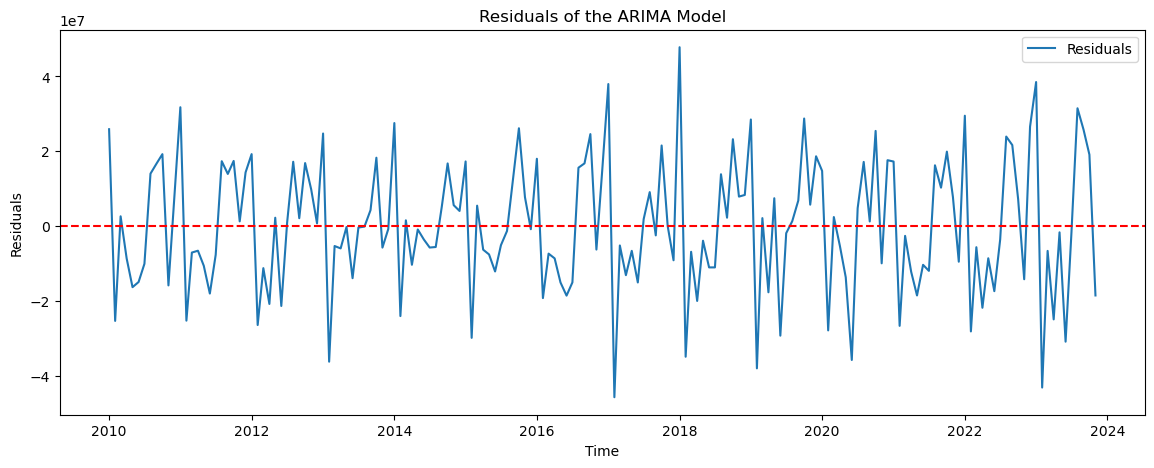

In [22]:
# Plot the residuals
residuals = arima_model_fit.resid

# Plot residuals over time
plt.figure(figsize=(14, 5))
plt.plot(residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals of the ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

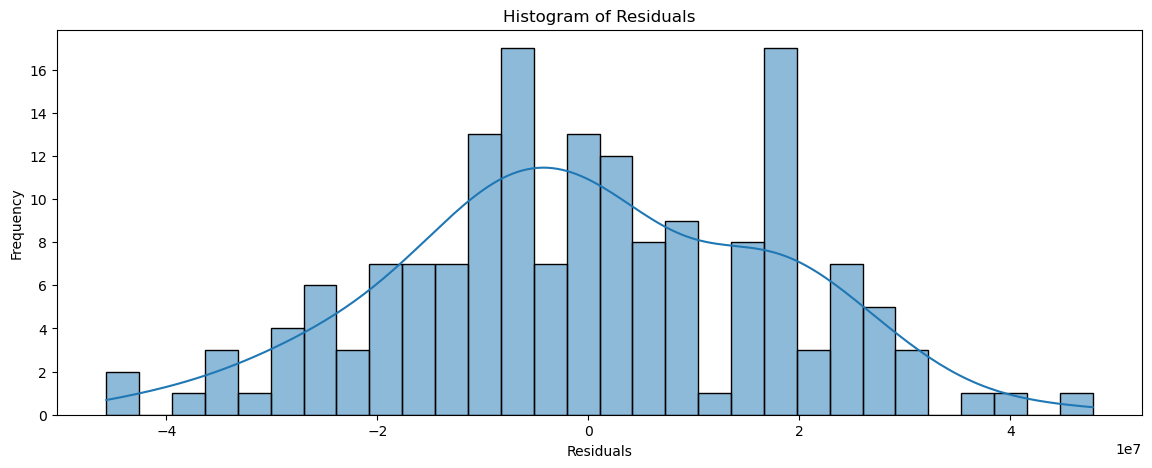

In [23]:
#Plot histogram of the residuals
plt.figure(figsize=(14, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

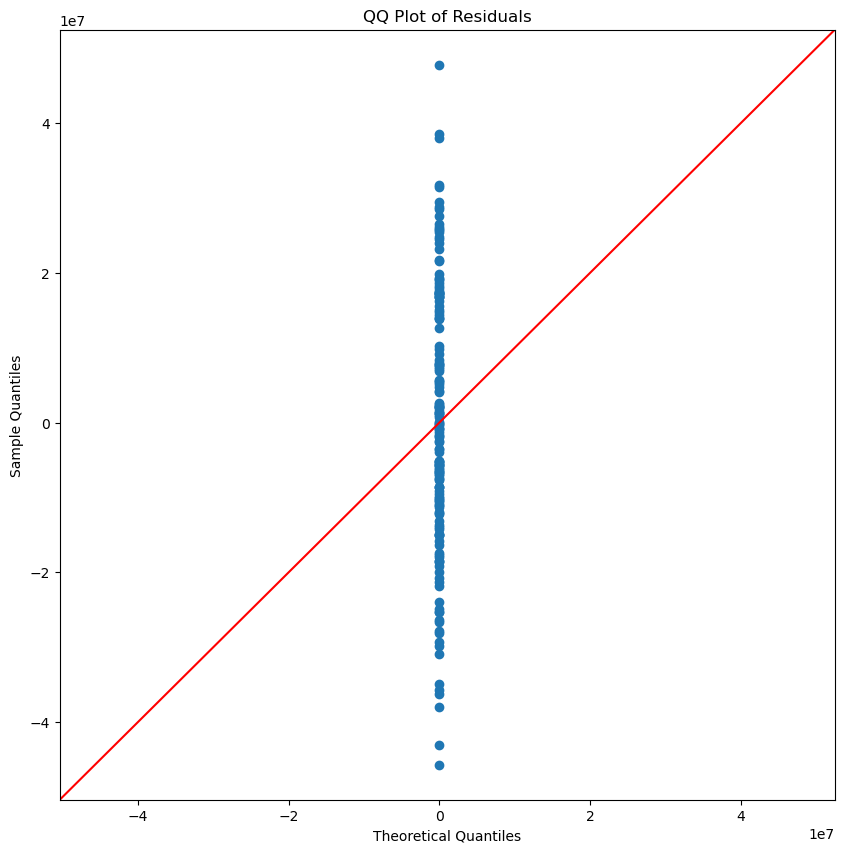

In [24]:
#QQ plot for normality check
plt.figure(figsize=(10, 10))
qqplot(residuals, line='45', ax=plt.gca())
plt.title('QQ Plot of Residuals')
plt.show()

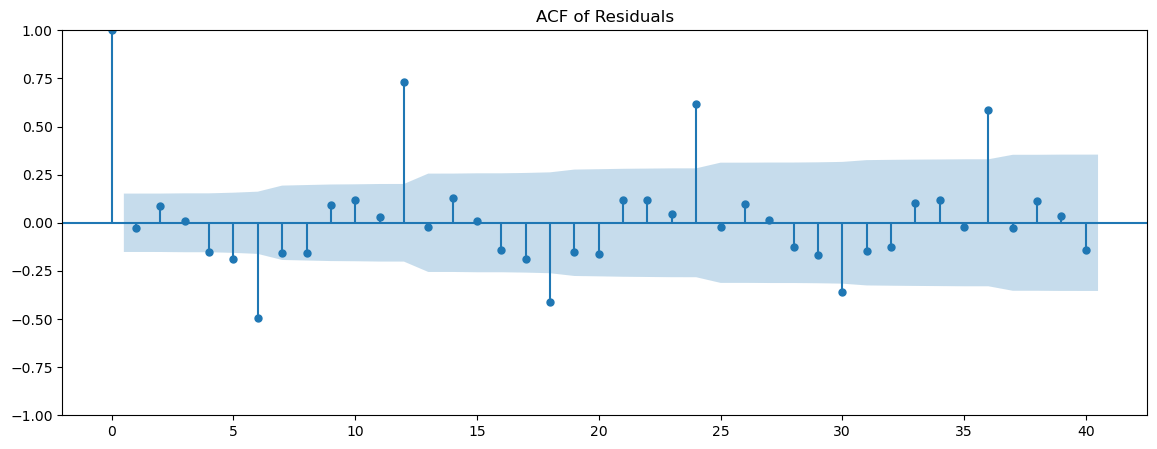

In [25]:
#Plot ACF of the residuals to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(14, 5))
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.show()

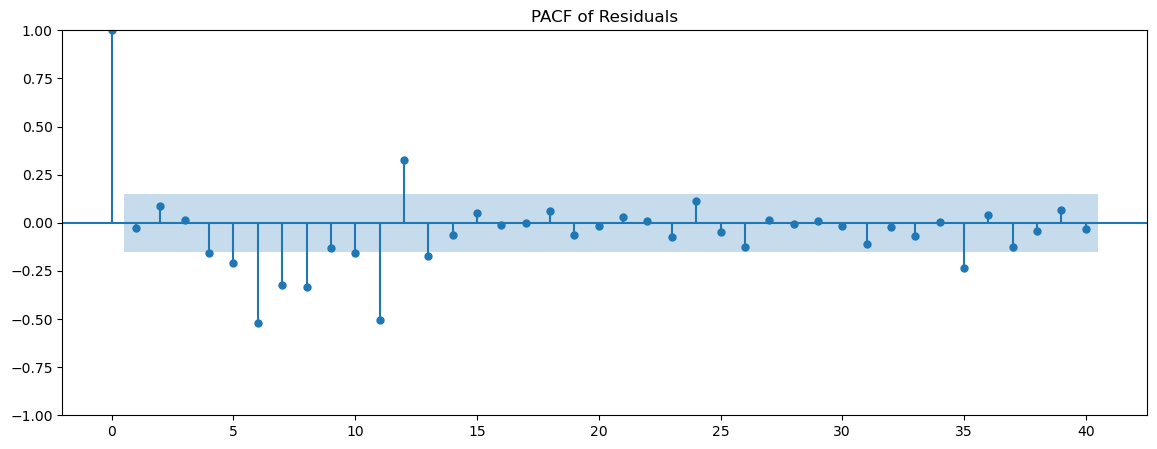

In [26]:
#Plot PACF of the residuals to check for partial autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(14, 5))
plot_pacf(residuals, lags=40, ax=plt.gca())
plt.title('PACF of Residuals')
plt.show()

In [27]:
#Forecast with ARIMA model
arima_forecast = arima_model_fit.get_forecast(steps=36)
arima_forecast_index = pd.date_range(start=data.index[1] + pd.DateOffset(months=1), periods=36, freq='M')
arima_forecast_values = arima_forecast.predicted_mean

In [28]:
#Re-integrate the forecasted differenced values back to original scale
last_observed = data['Sales_total'].iloc[-1]
arima_forecast_values_original = last_observed + arima_forecast_values.cumsum()

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# --- 1) Build aligned train/test on ORIGINAL series ---
y = data['Sales_total'].astype(float)

# Use last 20% of data as test
split_idx = int(len(y) * 0.8)
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

# --- 2) Create differenced series for training the model ---
y_train_diff = y_train.diff().dropna()

# --- 3) Fit ARIMA on differenced series (d=0 here because we already differenced) ---
model = ARIMA(y_train_diff, order=(2,0,2))
fit = model.fit()

# --- 4) Forecast on the differenced scale for the test period ---
diff_forecast = fit.forecast(steps=len(y_test))  # predictions of monthly CHANGE

# --- 5) Inverse-difference to original scale ---
last_train_level = y_train.iloc[-1]
level_forecast = last_train_level + diff_forecast.cumsum()
level_forecast.index = y_test.index  # align indices with test

# --- 6) Compute error metrics on ORIGINAL scale ---
rmse = np.sqrt(mean_squared_error(y_test, level_forecast))
mae  = mean_absolute_error(y_test, level_forecast)
mape = (np.abs((y_test - level_forecast) / y_test).mean()) * 100

print(f"RMSE (original units): {rmse:,.0f}")
print(f"MAE  (original units): {mae:,.0f}")
print(f"MAPE (%): {mape:.2f}")

RMSE (original units): 26,046,784
MAE  (original units): 20,938,192
MAPE (%): 6.36


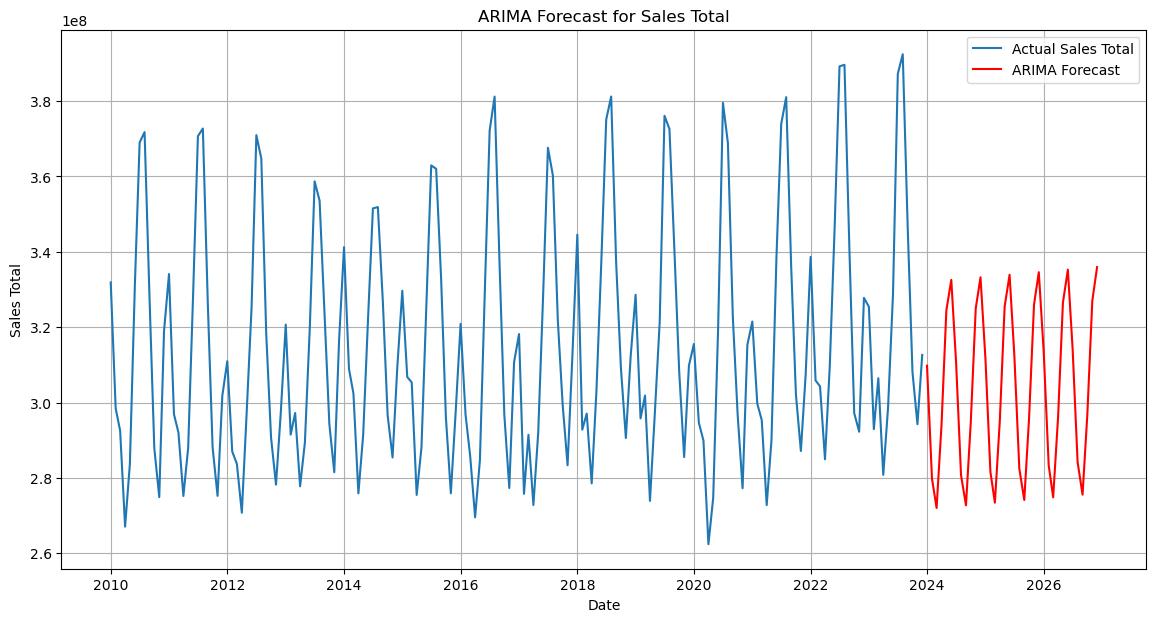

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Sales_total'], label='Actual Sales Total')
plt.plot(arima_forecast_index, arima_forecast_values_original, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast for Sales Total')
plt.xlabel('Date')
plt.ylabel('Sales Total')
plt.legend()
plt.grid(True)
plt.show()

## SARIMA 

In [31]:
# --- SARIMA Model ---

# Decomposing the time series
decomposition = seasonal_decompose(data['Sales_total'], model='additive', period=12)

In [32]:
# Extracting the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

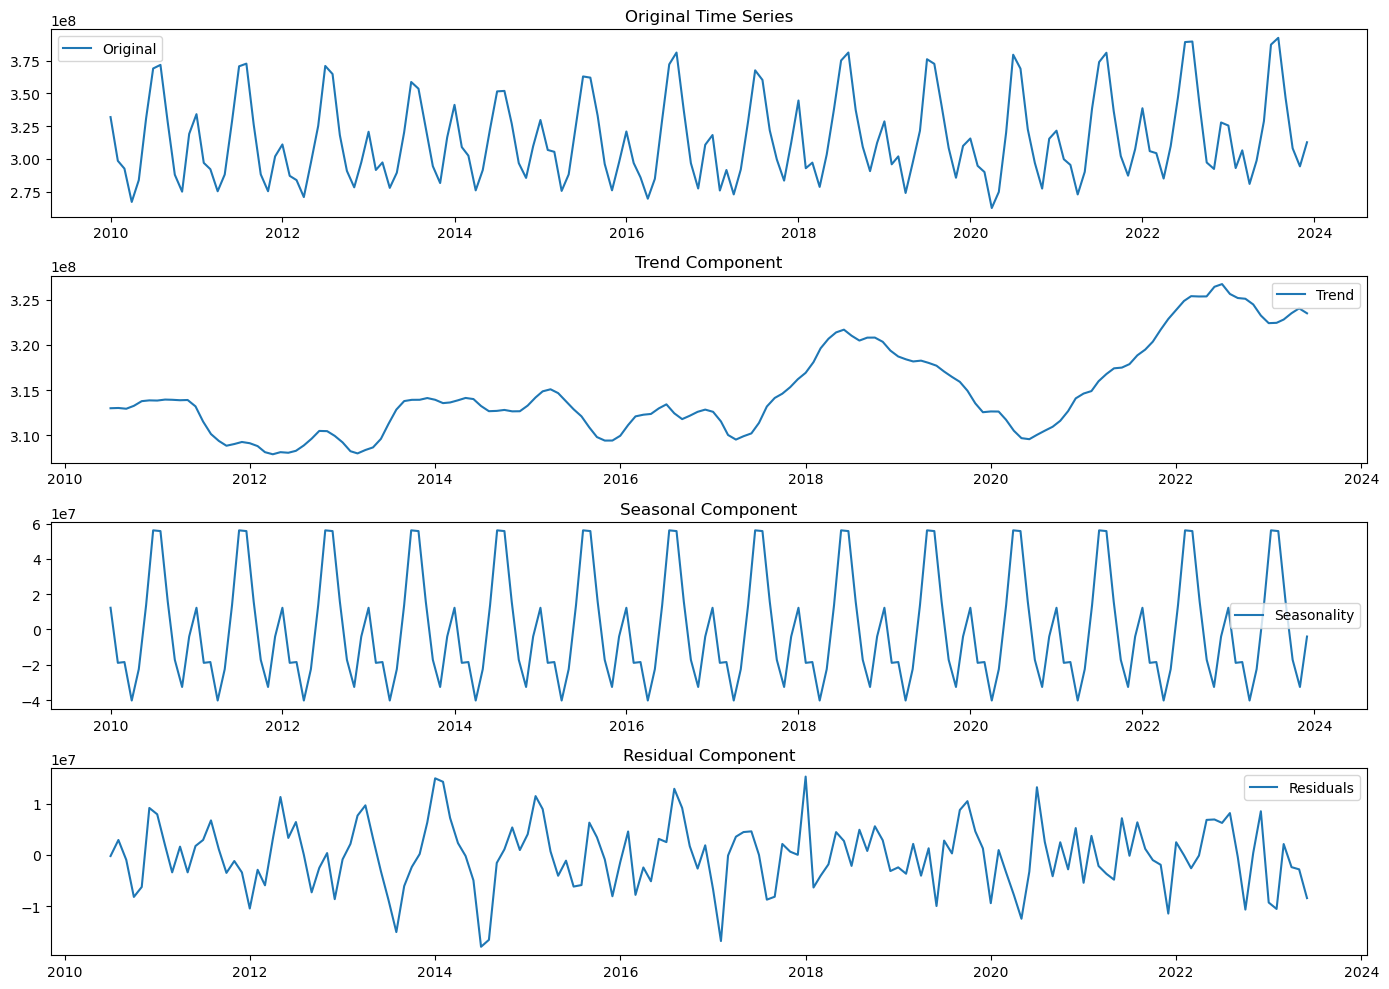

In [33]:
# Plotting the original series and its components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data.index, data['Sales_total'], label='Original')
plt.title('Original Time Series')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(data.index, trend, label='Trend')
plt.title('Trend Component')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(data.index, seasonal, label='Seasonality')
plt.title('Seasonal Component')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(data.index, residual, label='Residuals')
plt.title('Residual Component')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [34]:
#Fit SARIMA model using auto_arima
sarima_model_auto = auto_arima(
    data['Sales_total'],
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)
print("Auto SARIMA Model Summary:")
print(sarima_model_auto.summary())

#Fit SARIMA model with specified parameters
sarima_model_manual = SARIMAX(
    data['Sales_total'],
    order=(1, 0, 2),  # Non-seasonal pdq
    seasonal_order=(2, 1, 2, 12)  # Seasonal P, D, Q, s
)
sarima_model_fit = sarima_model_manual.fit()
print("SARIMA Model (Manual Order) Summary:")
print(sarima_model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=5469.633, Time=1.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5472.709, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5466.112, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=5462.923, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5472.076, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=5461.071, Time=0.09 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=5462.931, Time=0.19 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=5463.327, Time=0.73 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=5465.605, Time=0.21 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=5464.003, Time=0.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5464.203, Time=0.07 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=5465.842, Time=0.24 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=5460.268, Time=0.06 sec
 ARIMA(0,0,1)(1,1,0)[12]             : AIC=5462.237, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

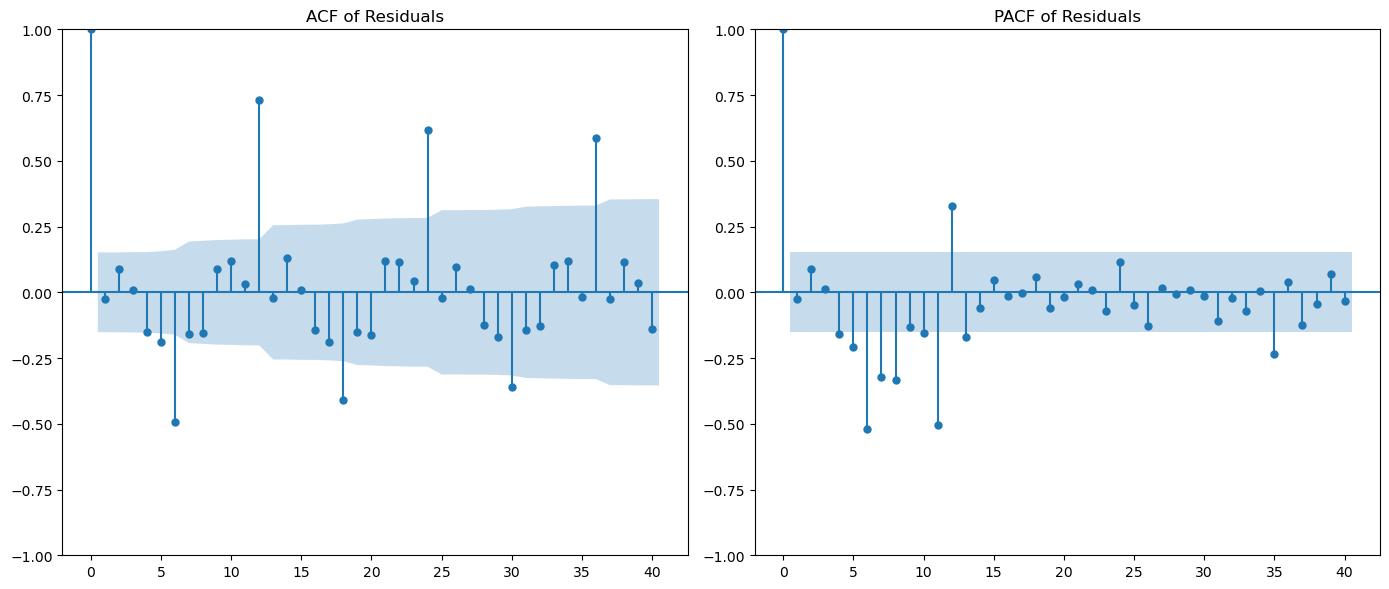

In [36]:
# Step 1: Residual plot
# ACF and PACF plots of residuals
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(residuals, lags=40, ax=plt.gca(), title='ACF of Residuals')

plt.subplot(122)
plot_pacf(residuals, lags=40, ax=plt.gca(), title='PACF of Residuals')

plt.tight_layout()
plt.show()

In [37]:
#Forecast with the SARIMA model
sarima_forecast = sarima_model_fit.get_forecast(steps=36)
sarima_forecast_index = pd.date_range(start=data.index[1] + pd.DateOffset(months=1), periods=36, freq='M')
sarima_forecast_values = sarima_forecast.predicted_mean

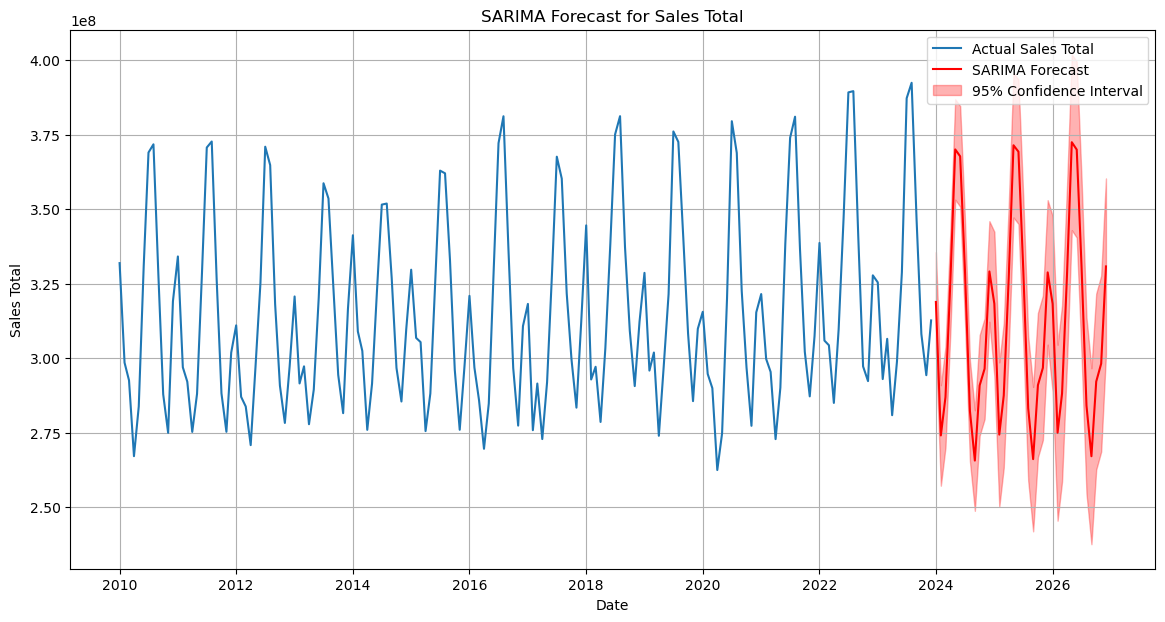

In [38]:
#Plot SARIMA forecast with confidence intervals
sarima_forecast_conf_int = sarima_forecast.conf_int()
lower_bound = sarima_forecast_conf_int.iloc[:, 0]
upper_bound = sarima_forecast_conf_int.iloc[:, 1]

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Sales_total'], label='Actual Sales Total')
plt.plot(sarima_forecast_index, sarima_forecast_values, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_index, lower_bound, upper_bound, color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMA Forecast for Sales Total')
plt.xlabel('Date')
plt.ylabel('Sales Total')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- 1) Build train-test split ---
y = data['Sales_total'].astype(float)
test_horizon = 12  # last 12 months for testing
train = y.iloc[:-test_horizon]
test  = y.iloc[-test_horizon:]

# --- 2) Fit SARIMA on training data ---
sarima_model = SARIMAX(train, order=(1, 0, 2), seasonal_order=(2, 1, 2, 12))
sarima_fit = sarima_model.fit(disp=False)

# --- 3) Forecast for the test period ---
sarima_forecast = sarima_fit.forecast(steps=len(test))

# --- 4) Compute error metrics ---
rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
mae = mean_absolute_error(test, sarima_forecast)
# Handle zero values in test to avoid division by zero
test_array = np.array(test)
forecast_array = np.array(sarima_forecast)
non_zero_indices = test_array != 0
mape = np.mean(np.abs((test_array[non_zero_indices] - forecast_array[non_zero_indices]) /
                      test_array[non_zero_indices])) * 100

print(f"SARIMA - RMSE: {rmse:,.0f}")
print(f"SARIMA - MAE: {mae:,.0f}")
print(f"SARIMA - MAPE: {mape:.2f}%")

SARIMA - RMSE: 5,315,865
SARIMA - MAE: 3,397,019
SARIMA - MAPE: 1.11%


## Prophet

In [43]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/47.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/47.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/47.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/47.8 kB ? eta -:--:--
     -------- ------------------------------- 10.2/47.8 kB ? eta -:--:--
     -------- ------------------------------- 10.2/47.8 kB ? eta -:--:--
     ---------------- --------------------- 20.5/47.8 kB 129.6 kB/s eta 0:00:01
     ---------------- --------------------- 20.5/47.8 kB 129.6 kB/s eta 0:00:01
     -------------------------------- ----- 41.0/47.8 kB 178.6 kB/s eta 0:00:01
     -------------------------------------- 47.8/47.8 kB 184.2 kB/s eta 0:00:00
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [41]:
sales_data = data[['Sales_total']]
print(sales_data.head())

            Sales_total
Date                   
2023-12-01  312641835.0
2023-11-01  294248486.0
2023-10-01  308065409.0
2023-09-01  346476441.0
2023-08-01  392436034.0


In [70]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# --- Load and prepare data ---
data = pd.read_excel('Elec_sales.xlsx', engine='openpyxl')

# Create datetime column and target
df = data[['Year', 'Month', 'Sales_total']].copy()
df['ds'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df['y'] = df['Sales_total']
df = df[['ds', 'y']]

# --- Split into train/test (last 12 months for testing) ---
test_horizon = 12
train = df.iloc[:-test_horizon]
test  = df.iloc[-test_horizon:]

# --- Fit Prophet model ---
model = Prophet()
model.fit(train)

# --- Forecast for the test period ---
future = pd.DataFrame({'ds': test['ds']})
forecast = model.predict(future)

# --- Extract predicted values ---
predicted = forecast['yhat'].values
actual = test['y'].values

# --- Calculate error metrics ---
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

# --- Print results ---
print("Prophet Performance on Test Set:")
print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAPE: {mape:.2f}%")

14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet Performance on Test Set:
MAE: 36,851,586
RMSE: 46,262,329
MAPE: 11.69%


13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
168 2023-12-31  3.254116e+08  3.166195e+08  3.343275e+08
169 2024-01-31  3.087605e+08  3.007799e+08  3.178797e+08
170 2024-02-29  3.149251e+08  3.064226e+08  3.235459e+08
171 2024-03-31  2.873975e+08  2.789235e+08  2.961349e+08
172 2024-04-30  3.048947e+08  2.964913e+08  3.132503e+08
173 2024-05-31  3.375804e+08  3.291028e+08  3.464517e+08
174 2024-06-30  3.809108e+08  3.724711e+08  3.892908e+08
175 2024-07-31  3.855270e+08  3.778287e+08  3.939080e+08
176 2024-08-31  3.506512e+08  3.420616e+08  3.593832e+08
177 2024-09-30  3.128084e+08  3.043426e+08  3.217272e+08
178 2024-10-31  2.986789e+08  2.901483e+08  3.074049e+08
179 2024-11-30  3.218855e+08  3.128631e+08  3.308859e+08
180 2024-12-31  3.361026e+08  3.274837e+08  3.449090e+08
181 2025-01-31  3.113154e+08  3.029790e+08  3.198899e+08
182 2025-02-28  3.207573e+08  3.118742e+08  3.295606e+08
183 2025-03-31  2.907214e+08  2.824432e+08  2.989228e+08
184 2025-04-30  3.079897e+08  2

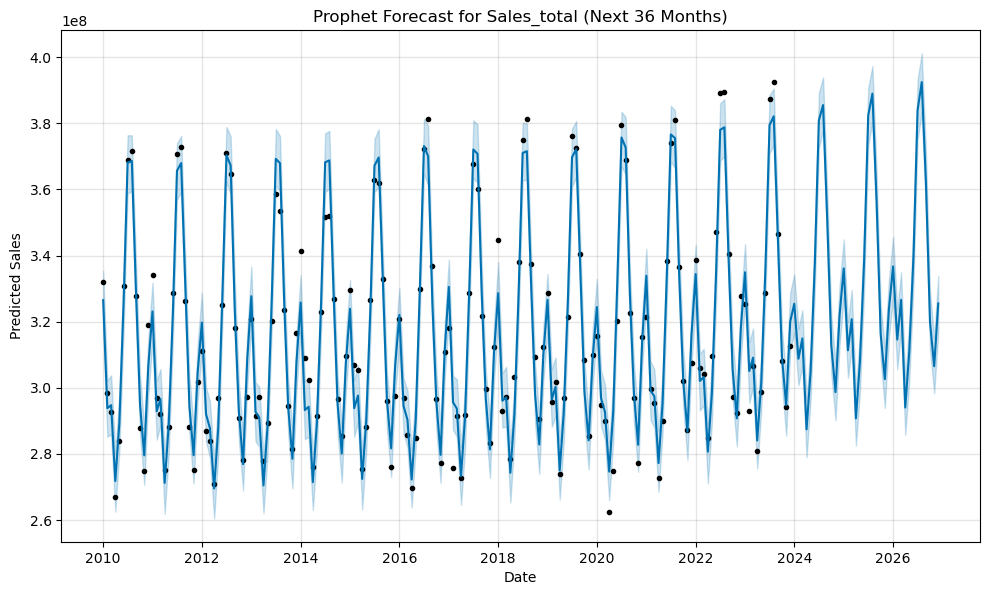

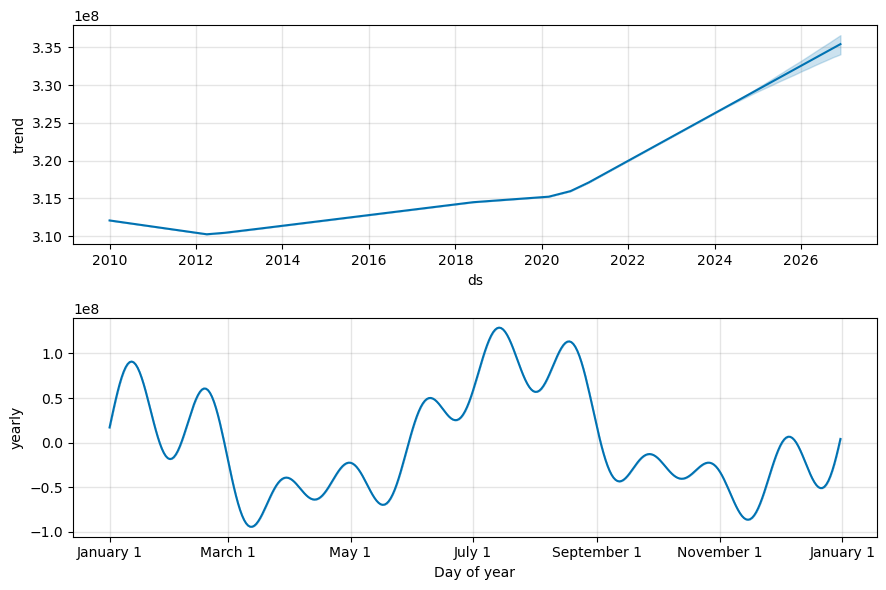

In [55]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_excel('Elec_sales.xlsx', engine='openpyxl')
# --- Prepare the data ---
# Combine Year and Month into a datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Prepare DataFrame for Prophet
prophet_data = data[['Date', 'Sales_total']].rename(columns={'Date': 'ds', 'Sales_total': 'y'})

# --- Initialize and fit Prophet ---
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# --- Forecast next 36 months ---
future = prophet_model.make_future_dataframe(periods=36, freq='M')
forecast = prophet_model.predict(future)

# --- Extract forecasted values for next 36 months ---
forecast_future = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(36)
print(forecast_future)

# --- Plot forecast ---
fig1 = prophet_model.plot(forecast)
plt.title("Prophet Forecast for Sales_total (Next 36 Months)")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.show()

# --- Plot forecast components (trend, yearly seasonality) ---
fig2 = prophet_model.plot_components(forecast)
plt.show()

## LSTM

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.1357 - val_loss: 0.0974
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0747 - val_loss: 0.0695
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0660 - val_loss: 0.0694
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0578 - val_loss: 0.0676
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0570 - val_loss: 0.0654
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0533 - val_loss: 0.0637
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0565 - val_loss: 0.0607
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0538 - val_loss: 0.0575
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0482 - val_loss: 0.0538
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0432 - val_loss: 0.0487
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0420 - val_loss: 0.0429
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0361 - val_lo

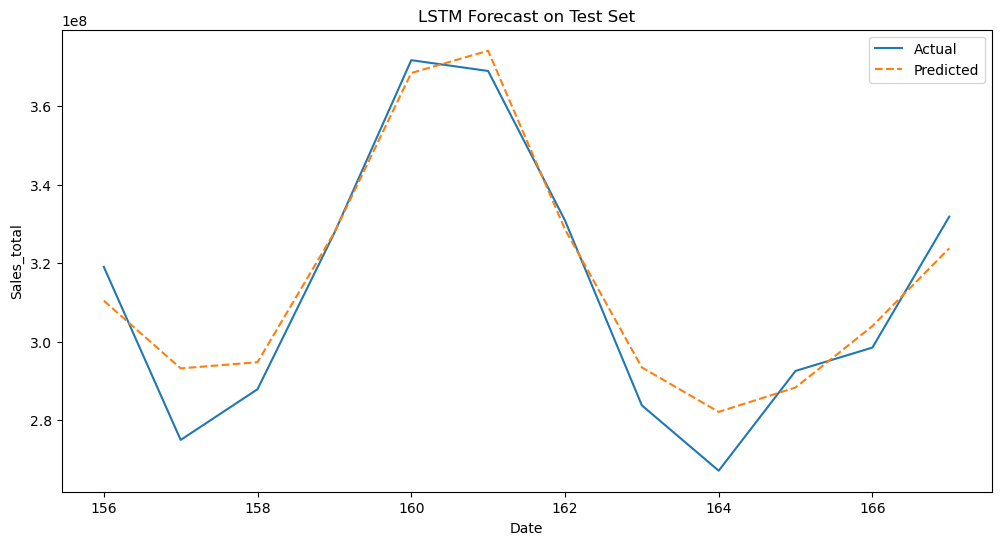

In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# --- Load dataset ---
data = pd.read_excel('Elec_sales.xlsx', engine='openpyxl')
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
sales = data[['Date', 'Sales_total']].set_index('Date')

# --- Scale the target ---
scaler = MinMaxScaler(feature_range=(0, 1))
sales_scaled = scaler.fit_transform(sales.values)

# --- Function to create sequences ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # past 12 months to predict next month
X, y = create_sequences(sales_scaled, seq_length)

# --- Train-test split (last 12 months for testing) ---
test_horizon = 12
X_train, X_test = X[:-test_horizon], X[-test_horizon:]
y_train, y_test = y[:-test_horizon], y[-test_horizon:]

# --- Build LSTM model ---
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- Train model ---
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# --- Predict on test set ---
y_pred_scaled = model.predict(X_test)
y_test_actual = scaler.inverse_transform(y_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

# --- Calculate metrics ---
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100

print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# --- Plot test set forecast ---
plt.figure(figsize=(12,6))
plt.plot(data.index[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(data.index[-len(y_test_actual):], y_pred_actual, label='Predicted', linestyle='--')
plt.title('LSTM Forecast on Test Set')
plt.xlabel('Date')
plt.ylabel('Sales_total')
plt.legend()
plt.show()

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2464
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1378
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0996 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0615
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0603 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0574 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0535 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0583
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0541
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0533
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0524 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0392
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0429 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0341
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss:

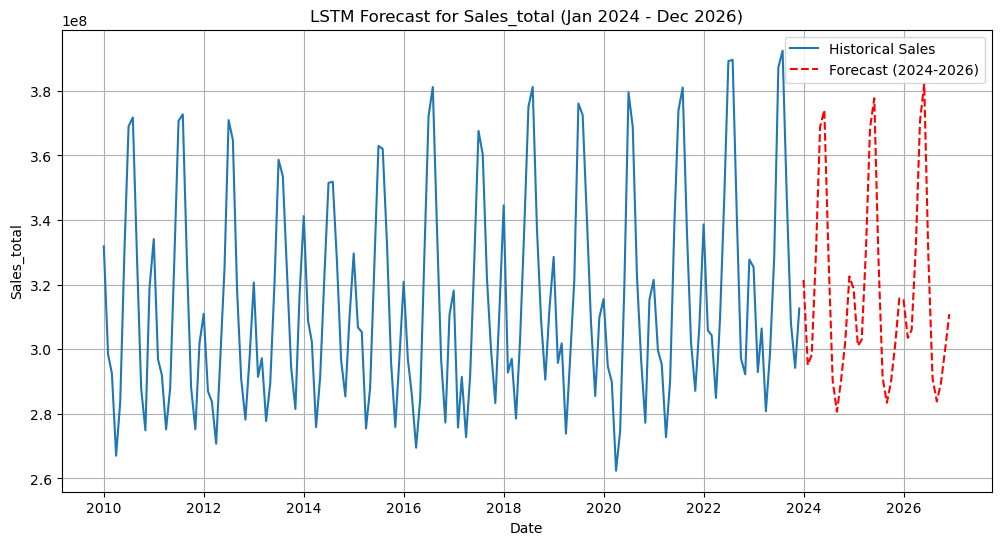

In [64]:
# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
data = pd.read_excel('Elec_sales.xlsx', engine='openpyxl')
# --- 1. Prepare the data ---
# Ensure proper datetime index
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
data.set_index('Date', inplace=True)

sales = data['Sales_total'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales)

# Sequence length (past months to use for prediction)
seq_length = 12

# Prepare sequences for LSTM
X, y = [], []
for i in range(seq_length, len(sales_scaled)):
    X.append(sales_scaled[i-seq_length:i])
    y.append(sales_scaled[i])
X, y = np.array(X), np.array(y)

# --- 2. Build LSTM model ---
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# --- 3. Train the model ---
model.fit(X, y, epochs=100, batch_size=16, verbose=1)

# --- 4. Forecast next 36 months (Jan 2024 - Dec 2026) ---
forecast_steps = 36
forecast_input = sales_scaled[-seq_length:]  # last 12 months as input
forecast_scaled = []

for _ in range(forecast_steps):
    pred = model.predict(forecast_input.reshape(1, seq_length, 1), verbose=0)[0]
    forecast_scaled.append(pred)
    forecast_input = np.vstack([forecast_input[1:], pred.reshape(1,1)])  # slide window

# Convert forecast back to original scale
forecast_actual = scaler.inverse_transform(np.array(forecast_scaled))

# --- 5. Create future dates exactly from Jan 2024 to Dec 2026 ---
forecast_dates = pd.date_range(start='2024-01-01', end='2026-12-01', freq='MS')

# Combine forecast into DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Sales_total': forecast_actual.flatten()
})

print(forecast_df)

# --- 6. Plot historical + forecast ---
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Sales_total'], label='Historical Sales')
plt.plot(forecast_dates, forecast_actual, linestyle='--', color='red', label='Forecast (2024-2026)')
plt.title('LSTM Forecast for Sales_total (Jan 2024 - Dec 2026)')
plt.xlabel('Date')
plt.ylabel('Sales_total')
plt.legend()
plt.grid(True)
plt.show()
